In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
import argparse
from typing import List, Tuple
import time
import matplotlib.pyplot as plt
import numpy as np
from metrics import evaluate
from tqdm import tqdm

In [8]:
# Initialize the device type based on compute resources being used
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# DO NOT CHANGE THIS LINE OF CODE!!!!
torch.manual_seed(4)

In [9]:
class TextDataset(Dataset):
    def __init__(self, train_input: str, word_to_idx: dict, tag_to_idx: dict, idx_to_tag: dict):
        """
        Initialize the dictionaries, sequences, and labels for the dataset

        :param train_input: file name containing sentences and their labels
        :param word_to_idx: dictionary which maps words (str) to indices (int). Should be initialized to {} 
            outside this class so that it can be reused for test data. Will be filled in by this class when training.
        :param tag_to_idx: dictionary which maps tags (str) to indices (int). Should be initialized to {} 
            outside this class so that it can be reused for test data. Will be filled in by this class when training.
        :param idx_to_tag: Inverse dictionary of tag_to_idx, which maps indices (int) to tags (str). Should be initialized to {} 
            outside this class so that it can be reused when evaluating the F1 score of the predictions later on. 
            Will be filled in by this class when training.
        """
        self.sequences = []
        self.labels = []
        i = 0 # index counter for word dict
        j = 0 # index counter for tag dict

        # for all sequences, convert the words/labels to indices using 2 dicts,
        # append these indices to the 2 lists, and add the resulting lists of
        # word/label indices to the accumulated dataset

        with open(train_input, 'r') as f:
            sequence = []
            label = []
            for line in f:
                if line.strip() == "":
                    self.sequences.append(sequence)
                    self.labels.append(label)
                    sequence = []
                    label = []
                else:
                    word, tag = line.strip().split('\t')
                    if word not in word_to_idx:
                        word_to_idx[word] = i
                        i += 1
                    if tag not in tag_to_idx:
                        tag_to_idx[tag] = j
                        idx_to_tag[j] = tag
                        j += 1
                    sequence.append(word_to_idx[word])
                    label.append(tag_to_idx[tag])

        
    def __len__(self):
        """
        :return: Length of the text dataset (# of sentences)
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Return the sequence of words and corresponding labels given input index

        :param idx: integer of the index to access
        :return word_tensor: sequence of words as a tensor
        :return label_tensor: sequence of labels as a tensor
        """
        word_tensor = torch.tensor(self.sequences[idx])
        label_tensor = torch.tensor(self.labels[idx])
        return word_tensor, label_tensor


class LinearFunction(Function):
    @staticmethod
    def forward(ctx, input: nn.Parameter, weight: nn.Parameter, bias: nn.Parameter):
        """
        Manual implementation of a Layer Linear forward computation that 
        also caches parameters for the backward computation. 

        :param ctx: context object to store parameters
        :param input: training example tensor of shape (batch_size, in_features)
        :param weight: weight tensor of shape (out_features, in_features)
        :param bias: bias tensor of shape (out_features)
        :return: forward computation output of shape (batch_size, out_features)
        """
        ctx.save_for_backward(input, weight)
        output = (torch.matmul(input, torch.transpose(weight, 0, 1)) 
                                            + bias.reshape((1, weight.shape[0])))
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Manual implementation of a Layer Linear backward computation 
        using the cached parameters from forward computation

        :param ctx: context object to access stored parameters
        :param grad_output: partial derviative w.r.t Linear outputs (What is the shape?)
        :returns:
            g_input: partial derivative w.r.t Linear inputs (Same shape as inputs)
            g_weight: partial derivative w.r.t Linear weights (Same shape as weights)
            g_bias: partial derivative w.r.t Linear bias (Same shape as bias, remember that bias is 1-D!!!)
        """
        input, weight = ctx.saved_tensors
        g_input = torch.matmul(grad_output, weight)
        g_weight = torch.matmul(torch.transpose(grad_output, 0, 1), input)
        g_bias = torch.sum(grad_output, dim=0)

        return g_input, g_weight, g_bias
    

class TanhFunction(Function):
    @staticmethod
    def forward(ctx, input):
        """
        Take the Tanh of input parameter

        :param ctx: context object to store parameters
        :param input: Activiation input (output of previous layers)
        :return: output of tanh activation of shape identical to input
        """
        output = torch.tanh(input)
        ctx.save_for_backward(output)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Performs backward computation of Tanh activation

        :param ctx: context object to access stored parameters
        :param grad_output: partial deriviative of loss w.r.t Tanh outputs
        :return: partial deriviative of loss w.r.t Tanh inputs
        """
        output, = ctx.saved_tensors
        grad_input = grad_output * (1 - output ** 2)
        return grad_input


class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        """
        Takes the ReLU of input parameter

        :param ctx: context object to store parameters
        :param input: Activation input (output of previous layers) 
        :return: Output of ReLU activation with shape identical to input
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Performs backward computation of ReLU activation

        :param ctx: context object to access stored parameters
        :param grad_output: partial deriviative of loss w.r.t ReLU output
        :return: partial deriviative of loss w.r.t ReLU input
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input


class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Initialize the dimensions and the weight and bias matrix for the linear layer.

        :param in_features: units in the input of the layer
        :param out_features: units in the output of the layer
        """

        super(Linear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # See https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        bound = torch.sqrt(1 / torch.tensor([in_features])).item()

        self.weight = nn.Parameter(nn.init.uniform_(
            torch.empty(out_features, in_features), a=-1*bound, b=bound))
        self.bias = nn.Parameter(nn.init.uniform_(
            torch.empty(out_features), a=-1*bound, b=bound))

    def forward(self, x):
        """
        Wrapper forward method to call the self-made Linear layer

        :param x: Input into the Linear layer, of shape (batch_size, in_features)
        """
        return LinearFunction.apply(x, self.weight, self.bias)


class Tanh(nn.Module):
    def __init__(self):
        super(Tanh, self).__init__()

    def forward(self, x):
        """
        Wrapper forward method to call the Tanh activation layer

        :param x: Input into the Tanh activation layer
        :return: Output of the Tanh activation layer
        """
        return TanhFunction.apply(x)


class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        Wrapper forward method to call the ReLU activation layer

        :param x: Input into the ReLU activation layer
        :return: Output of the ReLU activation layer
        """
        return ReLUFunction.apply(x)


class RNN(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, activation: str):
        """
        Initialize the embedding dimensions, hidden layer dimensions, 
        hidden Linear layers, and activation.

        :param embedding_dim: integer of the embedding size
        :param hidden_dim: integer of the dimension of hidden layer 
        :param activation: string of the activation type to use (Tanh, ReLU)
        """
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.W_hx = Linear(embedding_dim, hidden_dim)
        self.W_hh = Linear(hidden_dim, hidden_dim)

        if activation == 'tanh':
            self.activation = Tanh()
        elif activation == 'relu':
            self.activation = ReLU()
        else:
            raise Exception
    
    def forward(self, embeds):
        """
        Computes the forward pass for the RNN using the hidden layers
        and the input represented by embeddings. Sets initial hidden state to zeros.

        :param embeds: a batch of training examples converted to embeddings of size (batch_size, seq_length, embedding_dim)
        :returns: 
            outputs: list containing the final hidden states at each sequence length step. Each element has size (batch_size, hidden_dim),
            and has length equal to the sequence length
        """
        (batch_size, seq_length, embedding_dim) = embeds.shape
        hidden_states = []
        h_t = torch.zeros(batch_size, self.hidden_dim).to(device)

        for t in range(seq_length):
            x_t = embeds[:, t, :]
            h_t = self.activation(self.W_hx(x_t) + self.W_hh(h_t))
            hidden_states.append(h_t)

        return hidden_states


class TaggingModel(nn.Module):
    def __init__(self, vocab_size: int, tagset_size: int, embedding_dim: int, 
                hidden_dim: int, activation: str):
        """
        Initialize the underlying sequence model, activation name, 
        sequence embeddings and linear layer for use in the forward computation.
        
        :param vocab_size: integer of the number of unique "words" in our vocabulary
        :param tagset_size: integer of the the number of possible tags/labels (desired output size)
        :param embedding_dim: integer of the size of our sequence embeddings
        :param hidden_dim: integer of the hidden dimension to use in the Linear layer
        :param activation: string of the activation name to use in the sequence model
        """

        super(TaggingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = RNN(embedding_dim, hidden_dim, activation)
        self.hidden_to_tag = Linear(hidden_dim, tagset_size)
    
    def forward(self, sentences):
        """
        Perform the forward computation of the model (prediction), given batched input sentences.

        :param sentences: batched string sentences of shape (batch_size, seq_length) to be converted to embeddings 
        :return tag_distribution: concatenated results from the hidden to out layers (batch_size, seq_len, tagset_size)
        """
        embeds = self.embedding(sentences)
        hidden_states = self.rnn(embeds)
        tag_scores = [self.hidden_to_tag(h) for h in hidden_states]
        tag_scores = torch.stack(tag_scores, dim=1)
        return tag_scores
    

def calc_metrics(true_list, pred_list, tags_dict):
    """
    Calculates precision, recall and f1_score for lists of tags
    You aren't required to implement this function, but it may be helpful
    in modularizing your code.

    :param true_list: list of true/gold standard tags, in index form
    :param pred_list: list of predicted tags, in index form
    :param tags_dict: dictionary of indices to tags
    :return:
        (optional) precision: float of the overall precision of the two lists
        (optional) recall: float of the overall recall of the two lists
        f1_score: float of the overall f1 score of the two lists
    """
    true_list_tags = [tags_dict[i] for i in true_list]
    pred_list_tags = [tags_dict[i] for i in pred_list]
    precision, recall, f1_score = evaluate(true_list_tags, pred_list_tags)
    return precision, recall, f1_score


def train_one_epoch(model, dataloader, loss_fn, optimizer):
    """
    Trains the model for exactly one epoch using the supplied optimizer and loss function

    :param model: model to train 
    :param dataloader: contains (sentences, tags) pairs
    :param loss_fn: loss function to call based on predicted tags (tag_dist) and true label (tags)
    :param optimizer: optimizer to call after loss calculated
    """
    model.train()
    total_loss = 0
    for sentences, tags in dataloader:
        sentences = sentences.to(device)
        tags = tags.to(device)
        optimizer.zero_grad()
        tag_scores = model(sentences)
        loss = loss_fn(tag_scores.view(-1, tag_scores.shape[-1]), tags.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)
    
def test(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Compute the label and error rate.
    :param X: input data
    :param y: label
    :return:
        labels: predicted labels
        error_rate: prediction error rate
    """
    num_correct = 0
    predictions = np.zeros(len(y))
    for i in range(len(X)):
        y_hat, J = self.forward(X[i], y[i])
        y_hat_i = np.argmax(y_hat)
        predictions[i] = y_hat_i
        if y[i] == y_hat_i:
            num_correct += 1 
    
    error_rate = 1 - num_correct / len(y)
    return predictions, error_rate

def accuracy_score(true_labels, pred_labels):
    correct_predictions = 0
    for i in range(len(true_labels)):
        if true_labels[i] == pred_labels[i]:
            correct_predictions += 1
    accuracy = correct_predictions / len(true_labels) 
    return accuracy * 100

def predict_and_evaluate(model, dataloader, tags_dict, loss_fn):
    """
    Predicts the tags for the input dataset and calculates the loss, accuracy, and f1 score

    :param model: model to use for prediction
    :param dataloader: contains (sentences, tags) pairs
    :param tags_dict: dictionary of indices to tags
    :param loss_fn: loss function to call based on predicted tags (tag_dist) and true label (tags)
    :return:
        loss: float of the average loss over dataset throughout the epoch
        accuracy: float of the average accuracy over dataset throughout the epoch
        f1_score: float of the overall f1 score of the dataset
        all_preds: list of all predicted tag indices
    """

    model.eval()
    total_loss = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for sentences, tags in dataloader:
            sentences = sentences.to(device)  # shape: (batch_size, seq_length)
            tags = tags.to(device)  # shape: (batch_size, seq_length)
            tag_scores = model(sentences)  # shape: (batch_size, seq_length, tagset_size)
            loss = loss_fn(tag_scores.view(-1, tag_scores.shape[-1]), tags.view(-1))
            total_loss += loss.item()
            preds = torch.argmax(tag_scores, dim=-1)  # shape: (batch_size, seq_length)
            all_preds.extend(preds.view(-1).tolist())
            all_true.extend(tags.view(-1).tolist())
    
    precision, recall, f1 = calc_metrics(all_true, all_preds, tags_dict)
    accuracy = accuracy_score(all_true, all_preds)
    return total_loss / len(dataloader), accuracy, f1, all_preds

def train(train_dataloader, test_dataloader, model, optimizer, loss_fn, 
            tags_dict, num_epochs: int):
    """
    Trains the model for the supplied number of epochs. Performs evaluation on 
    test dataset after each epoch and accumulates all train/test accuracy/losses.

    :param train_dataloader: contains training data
    :param test_dataloader: contains testing data
    :param model: model module to train
    :param optimizer: optimizer to use in training loop
    :param loss_fn: loss function to use in training loop
    :param tags_dict: dictionary of indices to tags
    :param num_epochs: number of epochs to train
    :return:
        train_losses: list of integers (train loss across epochs)
        train_accuracies: list of integers (train accuracy across epochs)
        train_f1s: list of integers (train f1 score across epochs)        
        test_losses: list of integers (test loss across epochs)
        test_accuracies: list of integers (test accuracy across epochs)
        test_f1s: list of integers (test f1 score across epochs)
        final_train_preds: list of tags (final train predictions on last epoch)
        final_test_preds: list of tags (final test predictions on last epoch)
    """
    train_losses = []
    train_accuracies = []
    train_f1s = []
    test_losses = []
    test_accuracies = []
    test_f1s = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
        train_losses.append(train_loss)

        train_loss, train_acc, train_f1, train_preds = predict_and_evaluate(model, train_dataloader, tags_dict, loss_fn)
        train_accuracies.append(train_acc)
        train_f1s.append(train_f1)

        test_loss, test_acc, test_f1, test_preds = predict_and_evaluate(model, test_dataloader, tags_dict, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_f1s.append(test_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

    return train_losses, train_accuracies, train_f1s, test_losses, test_accuracies, test_f1s, train_preds, test_preds


In [10]:
def main(train_input: str, test_input: str, embedding_dim: int, hidden_dim: int,  num_epochs: int):
    activations = ['relu', 'tanh'] 
    train_f1s_all = {}
    test_f1s_all = {}

    for activation in activations:
        word_to_idx = {}
        tag_to_idx = {}
        idx_to_tag = {}

        train_dataset = TextDataset(train_input, word_to_idx, tag_to_idx, idx_to_tag)
        test_dataset = TextDataset(test_input, word_to_idx, tag_to_idx, idx_to_tag)

        train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        vocab_size = len(word_to_idx)
        tagset_size = len(tag_to_idx)

        model = TaggingModel(vocab_size, tagset_size, embedding_dim, hidden_dim, activation).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss()
        train_losses, train_accuracies, train_f1s, test_losses, test_accuracies, test_f1s, train_predictions, test_predictions = train(
            train_dataloader, test_dataloader, model, optimizer, loss_fn, idx_to_tag, num_epochs
        )
        train_f1s_all[activation] = train_f1s
        test_f1s_all[activation] = test_f1s

    for activation in activations:
        plt.plot(train_f1s_all[activation], label=f'{activation} train')  
        plt.plot(test_f1s_all[activation], label=f'{activation} val')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

Epoch 1/15, Train Loss: 0.3361, Train Acc: 88.5235, Train F1: 0.4818, Test Loss: 0.7516, Test Acc: 87.4928, Test F1: 0.3204
Epoch 2/15, Train Loss: 0.1974, Train Acc: 92.2877, Train F1: 0.6332, Test Loss: 0.8588, Test Acc: 88.9000, Test F1: 0.4174
Epoch 3/15, Train Loss: 0.1141, Train Acc: 95.3404, Train F1: 0.7555, Test Loss: 1.0282, Test Acc: 89.8350, Test F1: 0.4653
Epoch 4/15, Train Loss: 0.0838, Train Acc: 96.4482, Train F1: 0.8004, Test Loss: 1.1583, Test Acc: 90.1259, Test F1: 0.4816
Epoch 5/15, Train Loss: 0.0612, Train Acc: 97.5140, Train F1: 0.8467, Test Loss: 1.4490, Test Acc: 90.3883, Test F1: 0.4807
Epoch 6/15, Train Loss: 0.0408, Train Acc: 98.3566, Train F1: 0.8873, Test Loss: 1.8444, Test Acc: 90.7556, Test F1: 0.5013
Epoch 7/15, Train Loss: 0.0323, Train Acc: 98.7570, Train F1: 0.9158, Test Loss: 1.6955, Test Acc: 91.1086, Test F1: 0.5270
Epoch 8/15, Train Loss: 0.0328, Train Acc: 98.8382, Train F1: 0.9222, Test Loss: 2.0341, Test Acc: 91.2183, Test F1: 0.5269
Epoch 9/

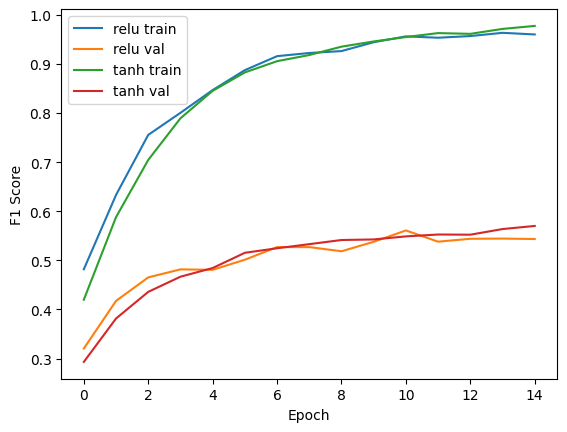

In [11]:
train_input = '/Users/pc/Documents/301/hw7-2/handout/data/en.train_40.twocol.oov'
test_input = '/Users/pc/Documents/301/hw7-2/handout/data/en.val_40.twocol.oov'
embedding_dim = 128
hidden_dim = 128
num_epochs = 15

main(train_input, test_input, embedding_dim, hidden_dim, num_epochs)

In [13]:
def main(train_input: str, test_input: str, num_epochs: int, activation: str):
    
    dimensions = [64, 128, 512]
    train_f1s_all = {}
    test_f1s_all = {} 

    for dim in dimensions:
        embedding_dim = hidden_dim = dim
        word_to_idx = {}
        tag_to_idx = {}
        idx_to_tag = {}

        train_dataset = TextDataset(train_input, word_to_idx, tag_to_idx, idx_to_tag)
        test_dataset = TextDataset(test_input, word_to_idx, tag_to_idx, idx_to_tag)

        train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        vocab_size = len(word_to_idx)
        tagset_size = len(tag_to_idx)

        model = TaggingModel(vocab_size, tagset_size, embedding_dim, hidden_dim, activation).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss()
        train_losses, train_accuracies, train_f1s, test_losses, test_accuracies, test_f1s, train_predictions, test_predictions = train(
            train_dataloader, test_dataloader, model, optimizer, loss_fn, idx_to_tag, num_epochs
        )
        train_f1s_all[dim] = train_f1s
        test_f1s_all[dim] = test_f1s

    # Plot results  
    for dim in dimensions:
        plt.plot(train_f1s_all[dim], label=f'{dim} train')
        plt.plot(test_f1s_all[dim], label=f'{dim} val')  
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

Epoch 1/5, Train Loss: 0.4828, Train Acc: 85.4073, Train F1: 0.3683, Test Loss: 0.7147, Test Acc: 85.3606, Test F1: 0.2712
Epoch 2/5, Train Loss: 0.3079, Train Acc: 89.6029, Train F1: 0.5155, Test Loss: 0.7579, Test Acc: 87.7218, Test F1: 0.3538
Epoch 3/5, Train Loss: 0.2104, Train Acc: 92.3675, Train F1: 0.6170, Test Loss: 0.8412, Test Acc: 88.9191, Test F1: 0.4107
Epoch 4/5, Train Loss: 0.1498, Train Acc: 94.3517, Train F1: 0.6987, Test Loss: 0.9320, Test Acc: 89.5726, Test F1: 0.4437
Epoch 5/5, Train Loss: 0.1096, Train Acc: 95.6366, Train F1: 0.7510, Test Loss: 1.0403, Test Acc: 90.0067, Test F1: 0.4628
Epoch 1/5, Train Loss: 0.4375, Train Acc: 86.5421, Train F1: 0.4150, Test Loss: 0.7643, Test Acc: 85.8662, Test F1: 0.2914
Epoch 2/5, Train Loss: 0.2496, Train Acc: 91.2625, Train F1: 0.5857, Test Loss: 0.8267, Test Acc: 88.3896, Test F1: 0.3867
Epoch 3/5, Train Loss: 0.1524, Train Acc: 94.2232, Train F1: 0.6969, Test Loss: 0.9231, Test Acc: 89.7777, Test F1: 0.4496
Epoch 4/5, Train

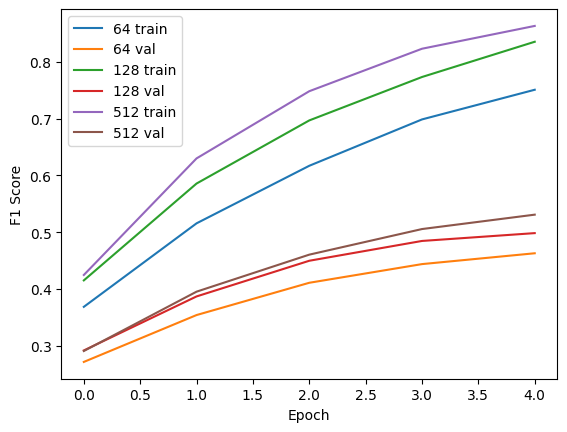

In [15]:
train_input = '/Users/pc/Documents/301/hw7-2/handout/data/en.train_40.twocol.oov'
test_input = '/Users/pc/Documents/301/hw7-2/handout/data/en.val_40.twocol.oov'
num_epochs = 5
activation = 'tanh'

main(train_input, test_input, num_epochs, activation)